In [1]:
# Settings
epochs = 50

is_colab = True
augment = True
should_plot = True

img_with = 256
img_size = [img_with, img_with]
img_dims = 3

monet_gen_losses = []
photo_gen_losses = []
monet_disc_losses = []
photo_disc_losses = []

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup tensorflow and devices

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import random

# Kaggle doesn't have drive and colab doesn't have kaggle_datasets
if is_colab:
    from google.colab import drive
else:
    from kaggle_datasets import KaggleDatasets
    import tensorflow_addons as tfa

# If we have a TPU available, we'll use it
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Replicas available:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

Device: 


Replicas available: 8


# Load in the dataset

In [4]:
if is_colab:
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/Colab Notebooks/Datasets/monet'
    models_path = f'/content/drive/MyDrive/Colab Notebooks/Big Data Intelligence/Final Project/models/models_epoch_{epochs}{"_augmented_exp" if augment else ""}'
else:
    path = KaggleDatasets().get_gcs_path('monet-gan-getting-started')
    models_path  = "/kaggle/input/monet-cyclegan-models/models_epoch_75_augmented-20241216T104407Z-001/models_epoch_75_augmented"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
paintings = tf.io.gfile.glob(f'{path}/monet_tfrec/*.tfrec')
print(f'The dataset contains: {len(paintings)} monet paintings')

photos = tf.io.gfile.glob(f'{path}/photo_tfrec/*.tfrec')
print(f'The dataset contains: {len(photos)} real photos')

The dataset contains: 5 monet paintings
The dataset contains: 20 real photos


In [6]:
# Turn the dataset into a list for easy access
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=img_dims)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*img_size, img_dims])
    return image

# Read the TFRecord file
def read_tfrecord(list):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    list = tf.io.parse_single_example(list, tfrecord_format)
    image = decode_image(list['image'])
    return image

In [7]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

# Data Augmentation

In [8]:
monet_ds = load_dataset(paintings, labeled=True).batch(1)
photo_ds = load_dataset(photos, labeled=True).batch(1)

#### Daniels insane image atmentation

In [9]:
# Data Augmentation function (only spatial transformations)
# Function to augment a single image (non-color-changing augmentations)
def augment_image(image):
    # Random flip left-right
    image = tf.image.random_flip_left_right(image)
    # Random flip up-down
    image = tf.image.random_flip_up_down(image)
    # Random rotation (90-degree steps)
    image = tf.image.rot90(image, k=np.random.randint(1, 4))  # Random 90, 180, 270 degrees
    # Return augmented image
    return image

# Function to generate augmented versions of the dataset
def augment_dataset(dataset, num_augmented_copies):
    augmented_dataset = dataset
    for _ in range(num_augmented_copies):
        augmented_images = dataset.map(
            lambda x: augment_image(x), num_parallel_calls=AUTOTUNE
        )
        augmented_dataset = augmented_dataset.concatenate(augmented_images)
    return augmented_dataset

In [10]:
if augment:
  # Increase the dataset size by creating 2 augmented copies of each image
  num_augmented_copies = 2
  augmented_monet_ds = augment_dataset(monet_ds, num_augmented_copies)
  # augmented_photo_ds = augment_dataset(photo_ds, num_augmented_copies)
  print(augmented_monet_ds.element_spec)
  # Shuffle and batch the datasets
  augmented_monet_ds = augmented_monet_ds.shuffle(1024).prefetch(AUTOTUNE)

  # augmented_monet_ds = augmented_monet_ds.shuffle(1024).batch(1).prefetch(AUTOTUNE)
  print(augmented_monet_ds.element_spec)
  # augmented_photo_ds = augmented_photo_ds.shuffle(1024).batch(1).prefetch(AUTOTUNE)

  # Check the size of the augmented dataset
  print("Original Monet dataset size:", len(list(monet_ds)))
  print("Augmented Monet dataset size:", len(list(augmented_monet_ds)))
  # print("Original Photo dataset size:", len(list(photo_ds)))
  # print("Augmented Photo dataset size:", len(list(augmented_photo_ds)))

  print(monet_ds.element_spec)
  monet_ds = augmented_monet_ds
  print(monet_ds.element_spec)

TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
Original Monet dataset size: 300
Augmented Monet dataset size: 900
TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)


In [11]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

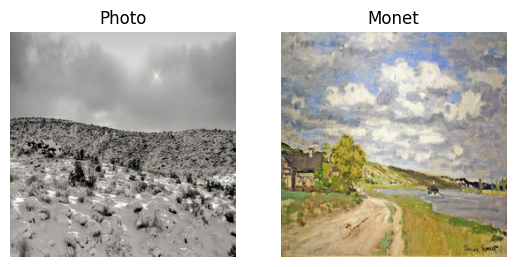

In [12]:
plt.subplot(121)
plt.title('Photo')
plt.axis('off')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.axis('off')
plt.imshow(example_monet[0] * 0.5 + 0.5)

# Chriss Custom Initializer

In [13]:
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer='ones',
            trainable=True,
            name="gamma"
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True,
            name="beta"
        )

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

# Build the generator

In [14]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(InstanceNormalization())

    result.add(layers.LeakyReLU())

    return result


In [15]:
def upsample(filters, size, apply_dropout=False, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    if apply_instancenorm:
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [16]:
OUTPUT_CHANNELS = 3

def Generator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=[256, 256, 3])

    # ---------- Encoder (Downsampling) ----------
    skips = []

    # Downsample 1: (bs, 256, 256, 3) -> (bs, 128, 128, 64)
    x = layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(inputs)
    x = layers.LeakyReLU()(x)
    skips.append(x)

    # Downsample 2: (bs, 128, 128, 64) -> (bs, 64, 64, 128)
    x = layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU()(x)
    skips.append(x)

    # Downsample 3: (bs, 64, 64, 128) -> (bs, 32, 32, 256)
    x = layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU()(x)
    skips.append(x)

    # Downsample 4-7: (bs, 32, 32, 256) -> (bs, 16, 16, 512) -> (bs, 8, 8, 512) -> (bs, 4, 4, 512) -> (bs, 2, 2, 512)
    for _ in range(4):
        x = layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
        x = InstanceNormalization()(x)
        x = layers.LeakyReLU()(x)
        skips.append(x)

    # ---------- Decoder (Upsampling) ----------
    # Reverse skips for skip connections (skip the last encoder output)
    skips = list(reversed(skips[:-1]))

    # Upsample: (bs, 2, 2, 512) -> (bs, 4, 4, 1024) -> concatenate -> (bs, 4, 4, 1024)
    for filters, apply_dropout, skip in zip(
        [512, 512, 512, 512, 256, 128, 64],
        [True, True, True, False, False, False, False],
        skips
    ):
        x = layers.Conv2DTranspose(filters, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
        x = InstanceNormalization()(x)
        if apply_dropout:
            x = layers.Dropout(0.5)(x)
        x = layers.ReLU()(x)
        x = layers.Concatenate()([x, skip])

    # Final layer: (bs, 128, 128, 64) -> (bs, 256, 256, 3)
    x = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')(x)

    return keras.Model(inputs=inputs, outputs=x)


# Build the discriminator

In [17]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    # Downsample 1: (bs, 256, 256, 3) -> (bs, 128, 128, 64)
    x = layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(inp)
    x = layers.LeakyReLU()(x)

    # Downsample 2: (bs, 128, 128, 64) -> (bs, 64, 64, 128)
    x = layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Downsample 3: (bs, 64, 64, 128) -> (bs, 32, 32, 256)
    x = layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Downsample 4: (bs, 32, 32, 256) -> (bs, 31, 31, 512)
    x = layers.ZeroPadding2D()(x)  # (bs, 34, 34, 256)
    x = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Final layer: (bs, 31, 31, 512) -> (bs, 30, 30, 1)
    x = layers.ZeroPadding2D()(x)  # (bs, 33, 33, 512)
    x = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs=inp, outputs=x)

In [18]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings

    photo_generator = Generator() # transforms Monet paintings to be more like photos
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

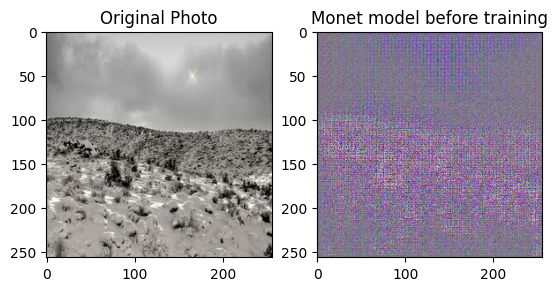

In [19]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet model before training")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

# Build the CycleGAN model

In [20]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

            # Add losses to our list
            monet_gen_losses.append(total_monet_gen_loss)
            photo_gen_losses.append(total_photo_gen_loss)
            photo_disc_losses.append(photo_disc_loss)
            monet_disc_losses.append(monet_disc_loss)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define loss functions

In [21]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [22]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [23]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [24]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the CycleGAN

In [25]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [26]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [27]:
# If we are on kaggle we skip this step and import instead
if is_colab:
    cycle_gan_model.fit(
        tf.data.Dataset.zip((monet_ds, photo_ds)),
        epochs=epochs
    )

Epoch 1/50
900/900 [==============================] - 281s 203ms/step - monet_gen_loss: 4.1453 - photo_gen_loss: 4.1709 - monet_disc_loss: 0.6661 - photo_disc_loss: 0.6651
Epoch 2/50
900/900 [==============================] - 183s 203ms/step - monet_gen_loss: 3.1465 - photo_gen_loss: 3.1640 - monet_disc_loss: 0.6430 - photo_disc_loss: 0.6417
Epoch 3/50
900/900 [==============================] - 183s 203ms/step - monet_gen_loss: 2.9309 - photo_gen_loss: 2.9669 - monet_disc_loss: 0.6362 - photo_disc_loss: 0.6340
Epoch 4/50
900/900 [==============================] - 183s 203ms/step - monet_gen_loss: 2.8596 - photo_gen_loss: 2.9356 - monet_disc_loss: 0.6330 - photo_disc_loss: 0.6138
Epoch 5/50
900/900 [==============================] - 183s 203ms/step - monet_gen_loss: 2.8078 - photo_gen_loss: 2.9329 - monet_disc_loss: 0.6384 - photo_disc_loss: 0.6051
Epoch 6/50
900/900 [==============================] - 184s 204ms/step - monet_gen_loss: 2.7174 - photo_gen_loss: 2.8793 - monet_disc_loss: 0

# Save/Load models

In [28]:
from keras.models import load_model

# We save our Model so we can add it to Kaggle
if is_colab:
    monet_generator.save(f'{models_path}/monet_generator')
    photo_generator.save(f'{models_path}/photo_generator')
    monet_discriminator.save(f'{models_path}/monet_discriminator')
    photo_discriminator.save(f'{models_path}/photo_discriminator')
# If we are on Kaggle, import our models
else:
    monet_generator.load_weights(f'{models_path}/monet_generator')
    photo_generator.load_weights(f'{models_path}/photo_generator')
    monet_discriminator.load_weights(f'{models_path}/monet_discriminator')
    photo_discriminator.load_weights(f'{models_path}/photo_discriminator')
    print("Models imported")

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which 

# Visualize our Monet-esque photos

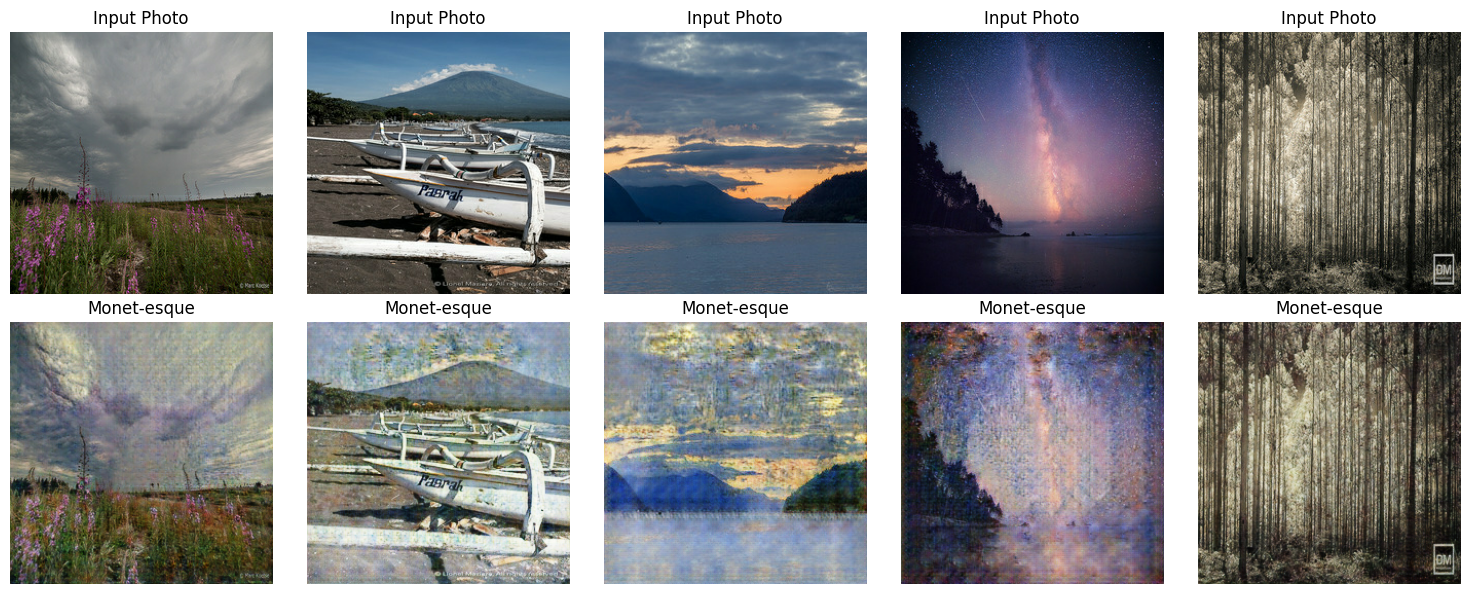

In [29]:
import random

_, ax = plt.subplots(2, 5, figsize=(15, 6))
random_photos = list(photo_ds.shuffle(buffer_size=100).take(5))  # Randomly shuffle and select 5 images

for i, img in enumerate(random_photos):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[0, i].imshow(img)  # Input photo in the first row
    ax[1, i].imshow(prediction)  # Monet-esque in the second row
    ax[0, i].set_title("Input Photo")
    ax[1, i].set_title("Monet-esque")
    ax[0, i].axis("off")
    ax[1, i].axis("off")

plt.tight_layout()
plt.show()


# Plot our losses

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(monet_gen_losses, label="Monet Generator Loss")
plt.plot(photo_gen_losses, label="Photo Generator Loss")
plt.plot(monet_disc_losses, label="Monet Discriminator Loss")
plt.plot(photo_disc_losses, label="Photo Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("CycleGAN Losses")
plt.show()

# Create submission file

In [ ]:
import PIL
! mkdir ../images

In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
    if i % 200 == 0:
        print(i)

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")